# Statistical Analysis of Germany's GDP with an AR-Model

## Import the relevant libraries

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

## Read in the dataset

In [4]:
gdp = pd.read_excel("GDP_Germany.xlsx")

## Change the format of the DataFrame

In [5]:
gdp = gdp.iloc[1].copy()

In [6]:
gdp = gdp.reset_index().copy()

In [7]:
gdp = gdp.rename(columns={"index": "year", 1: "GDP"}).copy()
gdp.drop(index=0, axis=1, inplace=True)
gdp = gdp.reset_index().copy()
gdp.drop(columns="index", axis=0, inplace=True)

## Plot the initial time series

Text(0, 0.5, 'GDP in Billion USD')

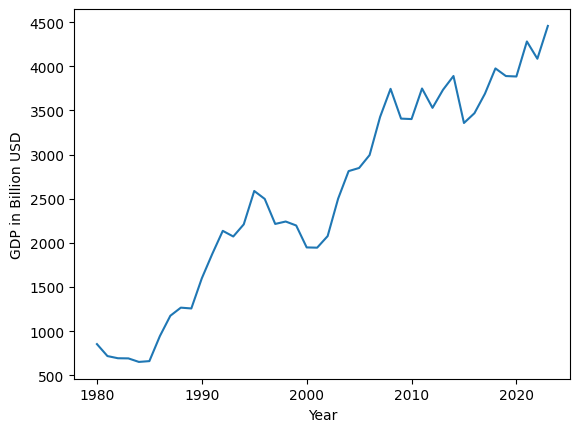

In [8]:
fig, ax = plt.subplots()
ax.plot("year", "GDP", data=gdp)
ax.set_xlabel("Year")
ax.set_ylabel("GDP in Billion USD")

# Time Series Analysis

### Is the time-series stationary?

In [9]:
from statsmodels.tsa.stattools import adfuller

In [10]:
# ADF-Test
result = adfuller(gdp["GDP"])
print("ADF Statistic: %f" % result[0])
print("p-value: %f" % result[1])
for key, value in result[4].items():
    print("Critical values:")
    print(f"  {key} {value}")

ADF Statistic: -0.727565
p-value: 0.839480
Critical values:
  1% -3.6327426647230316
Critical values:
  5% -2.9485102040816327
Critical values:
  10% -2.6130173469387756


p-value = 0.84 > 0.05 -> the time-series is non-stationary

### Differencing the time-series to make it stationary

In [11]:
gdp_differenced_1 = gdp.copy()
gdp_differenced_1["GDP"] = gdp.GDP.diff(1).copy()

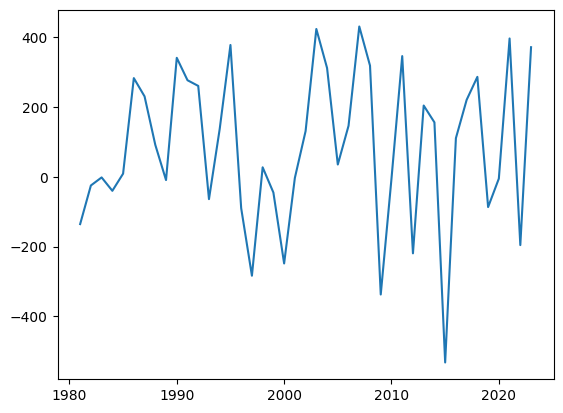

In [12]:
fig, ax = plt.subplots()
ax.plot("year", "GDP", data=gdp_differenced_1)

### Check again if time-series is now stationary with ADF

In [13]:
gdp_differenced_1.dropna(inplace=True)

# ADF-Test
result = adfuller(gdp_differenced_1["GDP"])
print("ADF Statistic: %f" % result[0])
print("p-value: %f" % result[1])
for key, value in result[4].items():
    print("Critical values:")
    print(f"  {key} {value}")

# now, the data is stationary, since the p-value < 0.05

ADF Statistic: -4.043530
p-value: 0.001199
Critical values:
  1% -3.6327426647230316
Critical values:
  5% -2.9485102040816327
Critical values:
  10% -2.6130173469387756


## Determining, which model will be used

- time-series was non-stationary
- we only have one time-series

In [14]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

### First, the parameters p and q have to be determined

In [15]:
from statsmodels.tsa.stattools import acf, pacf

gdp["GDP"] = gdp["GDP"].astype(float).copy()

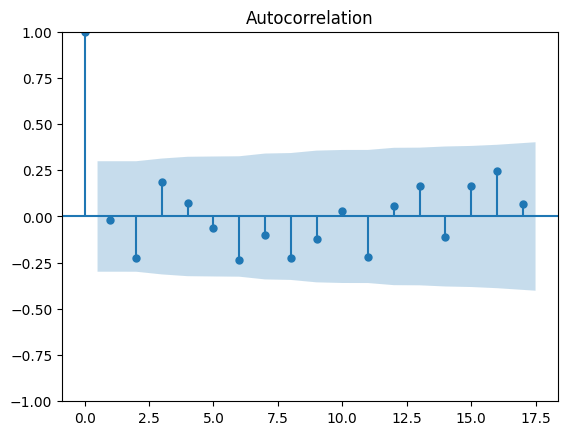

In [16]:
plot_acf(gdp_differenced_1["GDP"])
plt.show()

# the acf is used for determining the lags for the MA-Model
# it is clear, that no lag seems to be significantly different from zero, so we drop the MA-Model

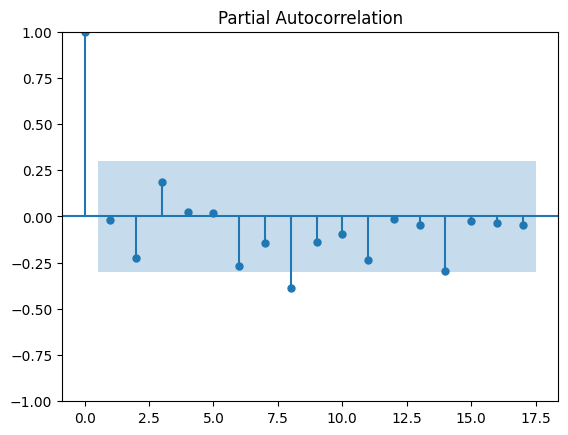

In [17]:
plot_pacf(gdp_differenced_1["GDP"])
plt.show()

# the pacf is used for determining the lags for the AR-Model
# here, the 8th lag seems to be fit, since it is significantly different from zero

!!! The PACF and ACF are rough measures for the lag-length. For a more precise determination, other measures (information criteria) are needed. For this short analysis, where the focus does not lie on the lag length but rather on implementing the model itself, the PACF and ACF are sufficient.

### AR(8)-Model

In [18]:
# lets start implementing the model
from statsmodels.tsa.ar_model import AutoReg

gdp_differenced_1["GDP"] = gdp_differenced_1["GDP"].astype(float).copy()
gdp_differenced_1["year"] = pd.to_datetime(gdp_differenced_1["year"], format='%Y').copy()
gdp_differenced_1 = gdp_differenced_1.set_index("year").copy()

In [19]:
gdp_differenced_1 = gdp_differenced_1.asfreq('YS')

In [20]:
res = AutoReg(gdp_differenced_1["GDP"], lags=8).fit()

In [21]:
print(res.summary())

                            AutoReg Model Results                             
Dep. Variable:                    GDP   No. Observations:                   43
Model:                     AutoReg(8)   Log Likelihood                -231.735
Method:               Conditional MLE   S.D. of innovations            181.644
Date:                Fri, 09 Aug 2024   AIC                            483.469
Time:                        10:07:10   BIC                            499.023
Sample:                    01-01-1989   HQIC                           488.838
                         - 01-01-2023                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        178.1104     49.191      3.621      0.000      81.699     274.522
GDP.L1        -0.0550      0.154     -0.357      0.721      -0.357       0.247
GDP.L2        -0.4948      0.158     -3.135      0.0

# Now, the model needs to be examined

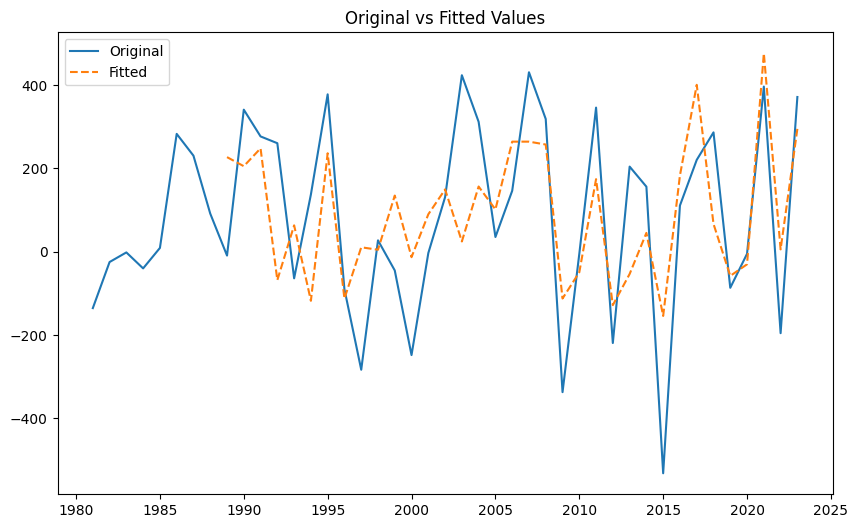

In [22]:
gdp_differenced_1['fitted'] = res.fittedvalues

plt.figure(figsize=(10, 6))
plt.plot(gdp_differenced_1['GDP'], label='Original')
plt.plot(gdp_differenced_1['fitted'], linestyle='--', label='Fitted')
plt.title('Original vs Fitted Values')
plt.legend()
plt.show()

# the plot shows, that the fitted values can predict the original data moderately well

## Examining the residuals...

In [23]:
from statsmodels.stats.diagnostic import het_white
from statsmodels.stats.stattools import jarque_bera

In [24]:
# Jarque-Bera-Test for checking normality of residuals

residuals = res.resid

jb_test = jarque_bera(residuals)
print(f'Jarque-Bera test statistic: {jb_test[0]}, p-value: {jb_test[1]}')

# the p-value is not smaller than 0.05, which means, that we cannot reject the null hypothesis
# therefore, the residuals are normal

Jarque-Bera test statistic: 0.5424467715075593, p-value: 0.7624461577704916


<Axes: >

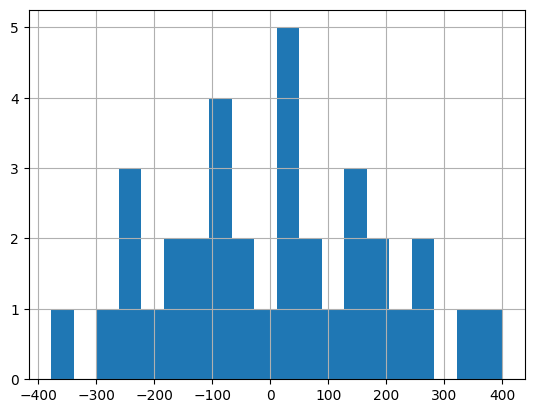

In [36]:
residuals.hist(bins=20)

In [26]:
# White-Test for checking, if the variance of the residuals is constant

exog = pd.DataFrame({f'lag_{i}': gdp_differenced_1["GDP"].shift(i) for i in range(1, 9)}).dropna()
residuals = residuals[-len(exog):]
exog = sm.add_constant(exog)

white_test = het_white(residuals, exog)
print(f'White test statistic: {white_test[0]}, p-value: {white_test[1]}')

# since the p-value > 0.05, the residuals are homoscedastic -> we are able to use the Breusch-Pagan-Test

White test statistic: 35.0, p-value: 0.4204039036649943


In [27]:
# Breusch-Godfrey-Test for checking, if the residuals are dependent

from statsmodels.stats.diagnostic import acorr_breusch_godfrey

bg_test_result = acorr_breusch_godfrey(res, nlags=4)

print(f'LM-Statistic: {bg_test_result[0]}')
print(f'p-value: {bg_test_result[1]}')

# p-value > 0.05 -> the residuals are not autocorrelated

LM-Statistic: 1.2340645581787206
p-value: 0.8724588962220063


-> Overall, the model seems to make robust estimations based on the conducted tests.

-> However, because of the small samplesize, results must still be interpreted with caution!

### $$Y_t = 178.11 - 0.06Y_{t-1} - 0.49Y_{t-2} + 0.37Y_{t-3} - 0.18Y_{t-4} + 0.34Y_{t-5} - 0.5Y_{t-6} - 0.003Y_{t-7} - 0.57Y_{t-8} + \epsilon_t$$